In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from modules.numeric import *
# from modules.default import Config
from modules.plotting import get_cmap

cmap = get_cmap()

In [36]:
L = 50
N = (L/40)*1000
dx = 2*L/N
dt = 0.7*dx

lamb = 0.5
v = 0.05
x0 = 10*np.sqrt(2/lamb)

collider = KinkCollider(x=np.arange(-L, L, dx), x0s=(-x0, x0), dt=dt, order=4)

In [40]:
def fix(t, y):
    y[1, :50].fill(0)
    y[1, -50:].fill(0)
    y[0, :50].fill(-1)
    y[0, -50:].fill(-1)

t_final = 2*x0/v + L
lat, y = collider.collide((v, -v), lamb, t_final, stop_conditions=[lambda t, y: np.any(np.isnan(y))], callbacks=[fix])

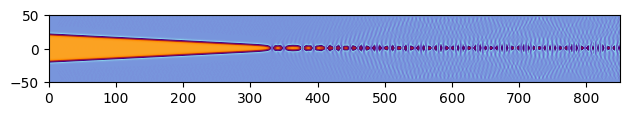

In [41]:
plt.imshow(y[:, 0].T, extent=(0, lat.t.max(), -L, L), cmap=cmap, vmin=-2, vmax=2)
# plt.ylim(-20, 20)
# plt.xlim(0, 100)
plt.gcf().tight_layout()
plt.show()

In [47]:
t_final = 2*x0/v + L
lat, y = collider.collide((-3*v, 0), lamb, t_final, stop_conditions=[lambda t, y: np.any(np.isnan(y))], callbacks=[fix])

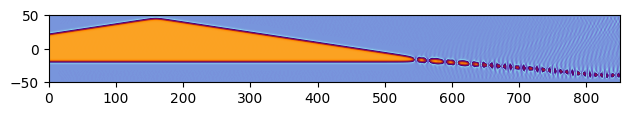

In [48]:
plt.imshow(y[:, 0].T, extent=(0, lat.t.max(), -L, L), cmap=cmap, vmin=-2, vmax=2)
# plt.ylim(-20, 20)
# plt.xlim(0, 100)
plt.gcf().tight_layout()
plt.show()

In [3]:
L = 200
N = (L/40)*1000
dx = 2*L/N
dt = 0.7*dx

collider = KinkCollider(x=np.arange(-L, L, dx), x0s=(-10, -5, 5, 10), dt=dt)

In [6]:
v = 0.3
lamb = 0.5

def fix(t, y):
    y[1, :10].fill(0)
    y[1, -10:].fill(0)

t_final = 3*L
lat, y = collider.collide((v, 0, 0, -v), lamb, t_final, stop_conditions=[lambda t, y: np.any(np.isnan(y))], callbacks=[fix])

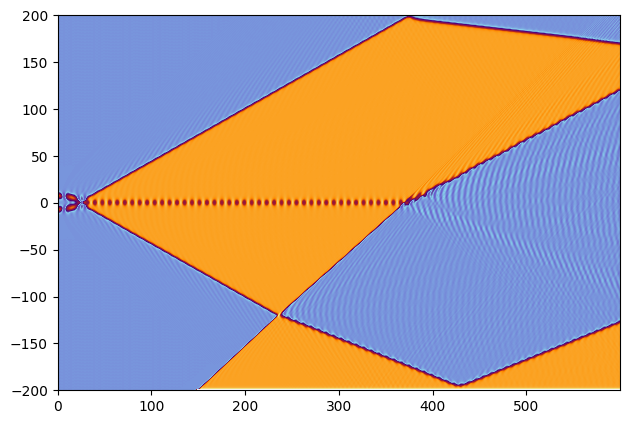

In [7]:
plt.imshow(y[:, 0].T, extent=(0, lat.t.max(), -L, L), cmap=cmap, vmin=-2, vmax=2)
# plt.ylim(-20, 20)
# plt.xlim(0, 100)
plt.gcf().tight_layout()

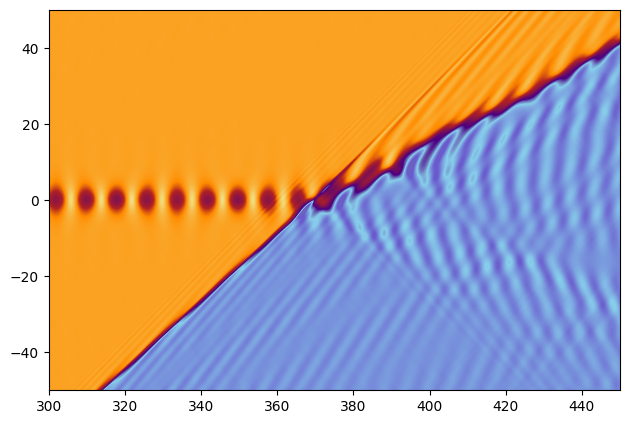

In [66]:
plt.imshow(y[:, 0].T, extent=(0, lat.t.max(), -L, L), cmap=cmap, vmin=-2, vmax=2)
plt.ylim(-50, 50)
plt.xlim(300, 450)
plt.gcf().tight_layout()

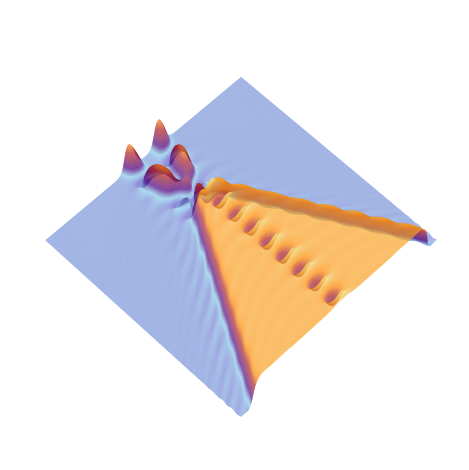

In [98]:
lims = lat.window(x=(-50, 50), t=(0, 100))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scl = 10
ax.plot_surface(*np.meshgrid(np.arange(-50, 50, lat.x[1]-lat.x[0]), np.arange(0, 100, lat.t[1]-lat.t[0])), scl*y[lims[1], 0, lims[0]],
                cmap=cmap, vmin=-2*scl, vmax=2*scl, linewidth=5, rstride=3, cstride=3)

ax.set_aspect('equal')
ax.axis('off')
ax.view_init(60, 45)
plt.gcf().tight_layout()
plt.show()

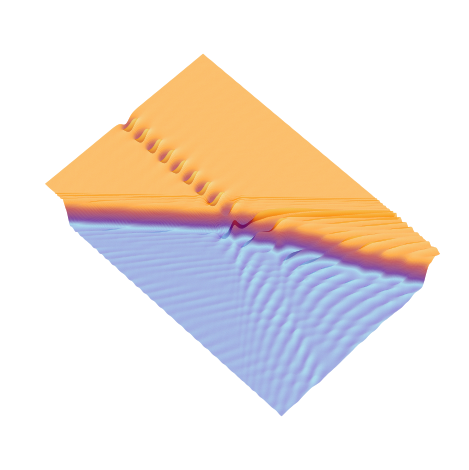

In [95]:
lims = lat.window(x=(-50, 50), t=(300, 450))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scl = 10
ax.plot_surface(*np.meshgrid(np.arange(-50, 50, lat.x[1]-lat.x[0]), np.arange(300, 450, lat.t[1]-lat.t[0])), scl*y[lims[1], 0, lims[0]],
                cmap=cmap, vmin=-2*scl, vmax=2*scl, linewidth=0, rstride=3, cstride=3)

ax.set_aspect('equal')
ax.axis('off')
ax.view_init(60, 45)
plt.gcf().tight_layout()
plt.show()

/tmp/ipykernel_16090/3725139720.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(1 + y[:, 0].T)), extent=(0, lat.t.max(), -L, L), cmap=cmap, vmin=-2, vmax=2)


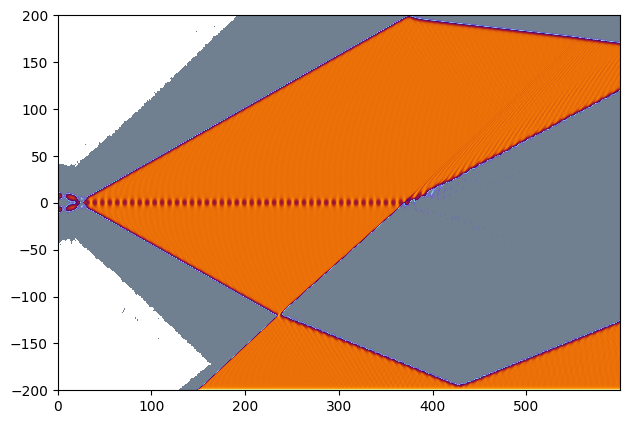

In [62]:
plt.imshow(np.log(np.abs(1 + y[:, 0].T)), extent=(0, lat.t.max(), -L, L), cmap=cmap, vmin=-2, vmax=2)
# plt.ylim(-20, 20)
# plt.xlim(0, 100)
plt.gcf().tight_layout()

[]

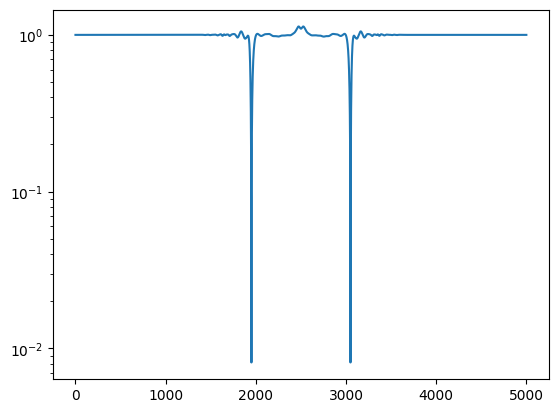

In [70]:
plt.plot(np.abs(y[lat.at(t=100)[-1], 0, :]))
plt.semilogy()

In [144]:
x0 = 10
v = 0.6
lamb = 10

t_final = 2*L
y = collider.collide((-10, -5, 5, 10), (v, 0, 0, -v), lamb, t_final)

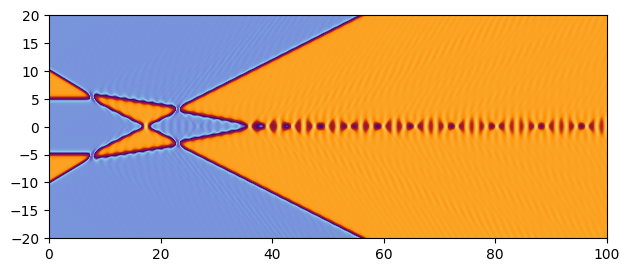

In [145]:
plt.imshow(y.T, extent=(0, t_final, -L, L), cmap=cmap, vmin=-2, vmax=2)
# plt.plot(np.linspace(0, t_final, len(y)), [np.abs(Config.x_lattice.x[np.argwhere(yt > 0)]).max() if len(np.argwhere(yt > 0)) else 0 for yt in y], 'w--')
plt.ylim(-20, 20)
plt.xlim(0, 100)
plt.gcf().tight_layout()

In [1]:
import sympy as sp

In [9]:
d = sp.symbols(r'\Delta')
sp.series((sp.log(1 + d)*(1 + d**2))**2)

\Delta**2 - \Delta**3 + 35*\Delta**4/12 - 17*\Delta**5/6 + O(\Delta**6)